In [1]:
import numpy as np
import scipy as sp
import sys
sys.path.append('/home/brad/code/sdme')
import sdme_logloss as sdme
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
Ndim = 2

trpmat = np.random.randn(2, 2, 2)
k = [0, 0]

def p(x, covmat=[[1, 0.6], [0.6, 1]]):
    
    return np.exp(-np.dot(np.dot(x.transpose(), covmat), x) - np.dot(k, x) )

def p2(x):
    return np.exp(-(x[0]**4 + x[1]**4))

In [ ]:
reload(sdme)
init = np.array([0.1, 0.1])
N_samples = 2000
N_burnin = 10000
N_skip = 1000
dx = 1

samples = sdme.mh_sampler(p, Ndim, N_samples, N_burnin, N_skip, init, dx)

In [ ]:
plt.scatter(samples[0, :], samples[1, :])


In [ ]:
print(np.dot(samples[0, :], samples[1, :]) / float(N_samples))
print(np.mean(samples[0, :]))

In [ ]:
reload(sdme)
N_neuron = 10
N = N_neuron
stimlen = 120
stimdim = 120
N_t = 100
beta_1 = np.random.randn(N_neuron, stimdim) / stimdim
beta_3= np.random.randn(N_neuron, N_neuron) / N_neuron

stim = np.random.randn(stimdim, stimlen)
resp_vec = 1.0*(np.random.uniform(size=(N_neuron, stimlen, 1)) >0.5)

In [ ]:
resp_vec.shape

In [ ]:
test, samps = sdme.sdme_logloss(stim, resp_vec, beta_1, 0, beta_3)
testd1, testd2, testd3 = sdme.sdme_dlogloss(stim, samps, beta_1, 0, beta_3, beta_1, 0, beta_3)

In [ ]:
order = 1
p_params = [stim, order, beta_1, 0, beta_3]
N_samples = 10
N_burnin = 50
N_skip = 10
init = resp_vec
dx = 0

tsamps = sdme.parallel_gibbs_sampler2(sdme.sdme_p, N_neuron, stimlen, 
                                      N_samples, N_burnin, N_skip, 
                                      init, dx, *p_params )

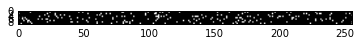

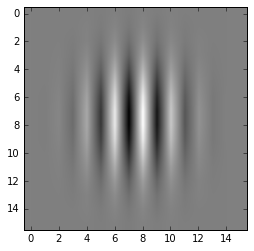

In [12]:
# Import data here.  In this case we will make our own. 
# First we generate some stimulus:
stim_dim = 16*16
stim_len = 2000
stim = np.random.randn(stim_dim, stim_len)
stim = 1.0*stim / np.max(stim)

# Next, we generate (first order) population receptive fields

N = 10  # Number of neurons
p=0.1
fo_rf = np.ones((N, stim_dim))
fo_rf[np.random.rand(N, stim_dim) > p] = 0
fo_rf[0, :] *= 0
plt.figure()
plt.set_cmap('gray')
plt.imshow(fo_rf)

# Generate Second Order Receptive fields

x = np.linspace(-1.0, 1.0, 16)
y = x
X, Y = np.meshgrid(x, y)
gb = np.exp(-(X**2 + Y**2)/0.25)*np.sin(2*np.pi*4*X)
plt.figure()
plt.set_cmap('gray')
plt.imshow(gb)

gbvec = np.squeeze(np.reshape(gb, (stim_dim, 1)))
eigvecmat = np.random.randn(stim_dim, stim_dim)
eigvecmat[0, :] = gbvec
eigvalmat = np.identity(stim_dim)/10.0
eigvalmat[0,0] = 1.0
stc_model = np.dot(np.linalg.inv(eigvecmat), np.dot(eigvalmat, eigvecmat))
stc_model_cube = np.zeros((N, stim_dim, stim_dim))
stc_model_cube[0, :, :] = stc_model
stimlen = stim_len

In [13]:
# generate data
p_params = [stim, 1, fo_rf, [], np.eye(N)]
sample_data = sdme.parallel_gibbs_sampler(sdme.sdme_p, N, stimlen, 20, 50, 100, 
                                          np.random.randn(N, stimlen), 0, *p_params)

In [ ]:
data_sta = sdme.data_to_sta(resp_vec, stim)
data_cov = sdme.data_to_cov(resp_vec)
data_stc = 0

sta_len = N*stimdim
stc_len = N*stimdim*stimdim
cov_len = N*N

sta_lin = np.reshape(data_sta, (sta_len,))
#stc_lin = np.reshape(data_stc, (stc_len,))
cov_lin = data_cov[np.triu_indices(N, 1)]
#cov_lin = np.reshape(data_cov, (cov_len,))
pstart = np.hstack((sta_lin, cov_lin))

def logloss(p):
    p_sta = np.reshape(p[0:sta_len], (N, stimdim))
    
    #p_stc = np.reshape(p[sta_len:sta_len+stc_len], (N, stim_dim, stim_dim))
    p_stc = 0
    p_cov = np.zeros((N, N))
    p_cov[np.triu_indices(N, 1)] = p[sta_len:]
    p_cov = p_cov + np.transpose(p_cov)
    #p_cov = np.reshape(p[sta_len+stc_len:], (N, N))
    
    return -1.0*sdme.sdme_logloss(stim, N, stimlen, p_sta, p_stc, p_cov)

def dlogloss(p):
    p_sta = np.reshape(p[0:sta_len], (N, stimdim))
    
    #p_stc = np.reshape(p[sta_len:sta_len+stc_len], (N, stim_dim, stim_dim))
    p_stc = 0
    #p_cov = np.reshape(p[sta_len+stc_len:], (N, N))
    p_cov = np.zeros((N, N))
    p_cov[np.triu_indices(N, 1)] = p[sta_len:]
    p_cov = p_cov + np.transpose(p_cov)
    [dA, dB, dC] = sdme.sdme_dlogloss(stim, N, data_sta, data_stc, data_cov, p_sta, p_stc, p_cov)
    dA_lin = np.reshape(dA, (sta_len,))
    dB_lin = np.array([0])
    dC_lin = dC[np.triu_indices(N, 1)]
    #dC_lin = np.reshape(dC, (cov_len,))
    logloss_grad = np.hstack((dA_lin, dC_lin ))
    return logloss_grad


In [ ]:
import scipy.optimize as opt
pfinal = opt.fmin_l_bfgs_b(logloss,pstart,fprime=dlogloss, factr = 1000, iprint=0)

In [ ]:
pfinal

In [ ]:
pout = pfinal[0]

In [ ]:
p_sta = np.reshape(pout[0:sta_len], (N, stimdim))
p_sta